# Getting Data for GW170817

In [2]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1','L1','V1']

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True) 

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd

Processing H1 data
Processing L1 data
Processing V1 data


# Unmarginalized Model single_template

Taking the polarization as a variable parameter with a prior as a numpy array with 5 points linearly spaced between 0 and 6.28.

In [3]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy as np
x=np.linspace(0,2*3.14,5)
static = {'mass1':1.3757,
          'mass2':1.3757,
          'f_lower':25.0,
          'approximant':"TaylorF2",
          'ra': 3.44615914,
          'dec': -0.40808407
         }                #go to the waveform genereator

variable = ('distance',
            'inclination',
            'tc',
           'polarization')        #sampling over these

prior = JointDistribution(variable,
                SinAngle(inclination=None),
                Uniform(
                    distance=(10, 100),
                    tc=(m.time-.2, m.time+0.2),
                    polarization=x
                )
        )

In [5]:
import copy
from pycbc.inference.models import SingleTemplate
model = SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl1 = sampler.EmceePTSampler(model, 3, 200, nprocesses=8)
_ = smpl1.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

In [6]:
%%time
smpl1.run_mcmc(100)

CPU times: user 2.49 s, sys: 274 ms, total: 2.76 s
Wall time: 1min 1s


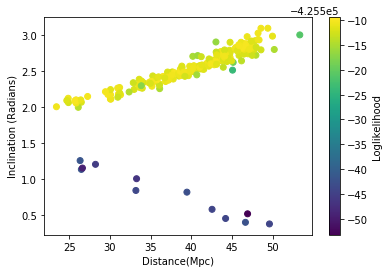

In [7]:
import pylab
lik = smpl1.model_stats['loglikelihood']
s = smpl1.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Distance(Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

For 200 iterations, convergence is better.

In [38]:
%%time
smpl1.run_mcmc(200)

CPU times: user 5.52 s, sys: 604 ms, total: 6.12 s
Wall time: 22.1 s


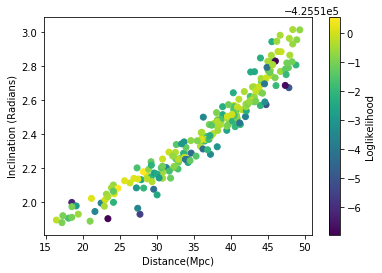

In [39]:
import pylab
lik = smpl1.model_stats['loglikelihood']
s = smpl1.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Distance(Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

# Marginalized over polarization single_template_p model

The model, edited to take into account polarization arrays, named SingleTemplate_p

In [10]:
import numpy
import scipy.special

from pycbc import filter as pyfilter
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector

from pycbc.inference.models.gaussian_noise import BaseGaussianNoise

# In this model we only calculate terms up to a constant.
# We are primarily interested in the posterior result


class SingleTemplate_p(BaseGaussianNoise):
    r"""Model that assumes we know all the intrinsic parameters.
    This model assumes we know all the intrinsic parameters, and are only
    maximizing over the extrinsic ones. We also assume a dominant mode waveform
    approximant only and non-precessing. Marginalizes over polarization angle, when it is input as an array.
    Parameters
    ----------
    variable_params : (tuple of) string(s)
        A tuple of parameter names that will be varied.
    data : dict
        A dictionary of data, in which the keys are the detector names and the
        values are the data (assumed to be unwhitened). All data must have the
        same frequency resolution.
    low_frequency_cutoff : dict
        A dictionary of starting frequencies, in which the keys are the
        detector names and the values are the starting frequencies for the
        respective detectors to be used for computing inner products.
    sample_rate : int, optional
        The sample rate to use. Default is 32768.
    \**kwargs :
        All other keyword arguments are passed to
        :py:class:`BaseGaussianNoise`; see that class for details.
    """
    name = 'single_template_p'

    def __init__(self, variable_params, data, low_frequency_cutoff,
                 sample_rate=32768, **kwargs):
        super(SingleTemplate_p, self).__init__(
            variable_params, data, low_frequency_cutoff, **kwargs)

        # Generate template waveforms
        df = data[self.detectors[0]].delta_f
        p = self.static_params.copy()
        if 'distance' in p:
            _ = p.pop('distance')
        if 'inclination' in p:
            _ = p.pop('inclination')
        hp, _ = get_fd_waveform(delta_f=df, distance=1, inclination=0, **p)

        # Extend template to high sample rate
        flen = int(int(sample_rate) / df) / 2 + 1
        hp.resize(flen)

        # Calculate high sample rate SNR time series
        self.sh = {}
        self.hh = {}
        self.det = {}
        for ifo in self.data:
            flow = self.kmin[ifo] * df
            fhigh = self.kmax[ifo] * df
            # Extend data to high sample rate
            self.data[ifo].resize(flen)
            self.det[ifo] = Detector(ifo)
            snr, _, _ = pyfilter.matched_filter_core(
                hp, self.data[ifo],
                psd=self.psds[ifo],
                low_frequency_cutoff=flow,
                high_frequency_cutoff=fhigh)

            self.sh[ifo] = 4 * df * snr
            self.hh[ifo] = -0.5 * pyfilter.sigmasq(
                hp, psd=self.psds[ifo],
                low_frequency_cutoff=flow,
                high_frequency_cutoff=fhigh)
        self.time = None

    def _loglr(self):
        r"""Computes the log likelihood ratio
        Returns
        -------
        float
            The value of the log likelihood ratio.
        """
        # calculate <d-h|d-h> = <h|h> - 2<h|d> + <d|d> up to a constant
        p = self.current_params.copy()
        p.update(self.static_params)

        if self.time is None:
            self.time = p['tc']

        shloglr = hhloglr = 0
        for ifo in self.sh:
            fp, fc = self.det[ifo].antenna_pattern(p['ra'], p['dec'],
                                                   p['polarization'],
                                                   self.time)
            dt = self.det[ifo].time_delay_from_earth_center(p['ra'],
                                                            p['dec'],
                                                            self.time)
            ip = numpy.cos(p['inclination'])
            ic = 0.5 * (1.0 + ip * ip)
            htf = (fp * ip + 1.0j * fc * ic) / p['distance']
            #print(htf)

            sh = self.sh[ifo].at_time(p['tc'] + dt) * htf
            shloglr += sh
            hhloglr += self.hh[ifo] * abs(htf) ** 2.0

        vloglr = numpy.log(scipy.special.i0e(abs(shloglr)))
        
        #An array of vloglr for each polarization value
        vloglr += abs(shloglr) + hhloglr 
        #putting all vloglr values in exp(vloglr)
        temp=numpy.exp(vloglr)
        #summing over the values in the array exp(vloglr)
        loglm=(numpy.sum(temp))
        
        #To handle the case where loglm=0; assigned a very small value to loglm that is not equal to 0
        #taking the log of loglm to obtain new loglikelihood ratio marginalized over pol
        
        if loglm!=0:
            return float(numpy.log(loglm))  
        else:
            return float(numpy.log(1e-20))

Taking polarization as a static parameter as a numpy array, 5 values linearly spaced between 0 and 6.28

In [12]:
#marginalized
from pycbc.inference import sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy as np
x=np.linspace(0,2*3.14,5)

static = {'mass1':1.3757,
              'mass2':1.3757,
              'f_lower':25.0,
              'approximant':"TaylorF2",
              'polarization':x,
              'ra': 3.44615914,
              'dec': -0.40808407
             }                          
    
variable = ('distance',
            'inclination',
            'tc',
           )        #sampling over these

prior = JointDistribution(variable,
                SinAngle(inclination=None), 
                Uniform(
                    distance=(10, 100),
                    tc=(m.time-.2, m.time+0.2)
                )
        )

In [13]:
#marginalized
import copy
model = SingleTemplate_p(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl = sampler.EmceePTSampler(model, 3, 200, nprocesses=8)
_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

In [22]:
%%time
smpl.run_mcmc(100)

CPU times: user 2.64 s, sys: 339 ms, total: 2.98 s
Wall time: 16.1 s


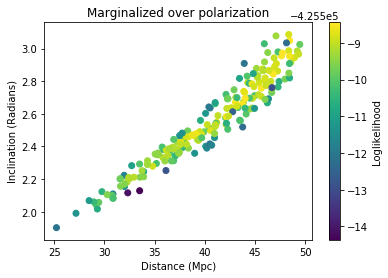

In [24]:
import pylab
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.title('Marginalized over polarization')
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

200 iterations

In [25]:
%%time
smpl.run_mcmc(200)

CPU times: user 5.06 s, sys: 508 ms, total: 5.57 s
Wall time: 31.7 s


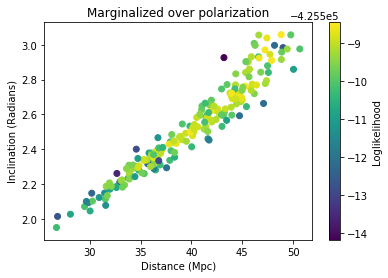

In [26]:
import pylab
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.title('Marginalized over polarization')
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

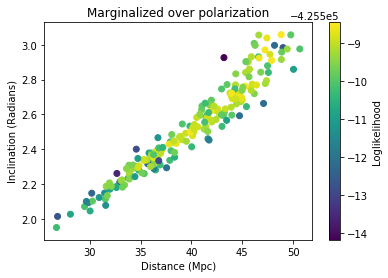

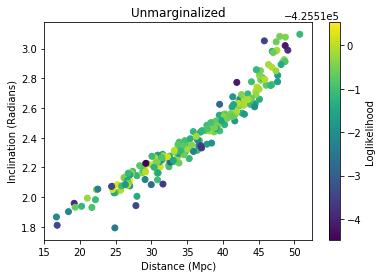

In [27]:
import pylab
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.title('Marginalized over polarization')
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()




import pylab
lik1 = smpl1.model_stats['loglikelihood']
s1 = smpl1.samples

pylab.scatter(s1['distance'][0,:,-1],
              s1['inclination'][0,:,-1],
              c=lik1[0,:,-1])
pylab.title('Unmarginalized')
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c1 = pylab.colorbar()
c1.set_label('Loglikelihood')
pylab.show()

## Unmarginalized model

In [32]:
%%time
smpl1.run_mcmc(200)

CPU times: user 5.25 s, sys: 558 ms, total: 5.81 s
Wall time: 22.1 s


## Marginalized Model

In [33]:
%%time
smpl.run_mcmc(200)

CPU times: user 5.71 s, sys: 697 ms, total: 6.41 s
Wall time: 32.5 s
